# CoSpar basics

Below, we walk you through typical steps of analysis. We use the subsampled hematopoiesis dataset so that this tutorial can be run within a few minutes.
For further demonstration, please see notebooks in the **Examples** section. 

**Contents**:
    
* Initialization

* Preprocessing and dimension reduction (optional)

* Raw clonal data analysis (without using state information)

* Transition map inference

* Plotting

* Miscellaneous

In [1]:
import cospar as cs

In [2]:
cs.settings.verbosity=3 #range: 0 (error),1 (warning),2 (info),3 (hint). Set it at a given value will print information at and below its level.  
cs.settings.set_figure_params(format='png',dpi=75,fontsize=14) # figure setting.

Each dataset should have its own folder to avoid conflicts.  

In [3]:
# set the directory for figures and data. If not existed yet, it will be created automtaically.
cs.settings.data_path='data_cospar' #data_path
cs.settings.figure_path='fig_path' 

## Initialization

The first step is to construct an ``anndata`` object that stores all relevant data. The input data are:

* **RNA_count_matrix**: shape (n_cell, n_gene), mandatory, stored at `adata.X` 

* **gene_names**: list of gene names, shape (n_genes,), mandatory, stored at `adata.var_names`

* **time_info**: list of time annotation in string, shape (n_cell,), mandatory, stored at `adata.obs['time_info']`

* **X_clone**: clonal label for each cell in the form of np.array or sparse matrix, shape (n_cell, n_clone), optional, stored at `adata.obsm['X_clone']`  
    
* **X_pca**: PCA matrixs, shape (n_cell, n_pcs), optional, stored at `adata.obsm['X_pca']`  

* **X_emb**: two-dimensional embedding, shape (n_cell, 2), optional, stored at `adata.obsm['X_emb']`  

* **state_info**: state annotation for each cell, shape (n_cell, 1), optional, stored at `adata.obsm['state_info']` 

The clonal data `X_clone` is optional. If not provided, cospar generates the transition map based on state information only.
A clone means a barcode that labels cells. We allow a cell to have multiple barcodes (possibly at different time points), thus belonging to multiple clones.   

`X_pca`, `X_emb`, and `state_info` are also optional. They can be generated in downstream preprocessing and dimension reduction steps. 

We provide a function to help to initialize this object. We mimic this step by loading a preprocessed dataset, extracting each component, 
and then re-assembling them using our initialization function. 

Load an existing dataset. If you have pre-processed data, you can load it with `cs.hf.read(file_name)`.

In [4]:
adata_orig_0=cs.datasets.hematopoiesis_subsampled()

  0%|          | 0.00/26.3M [00:00<?, ?B/s]

creating directory fig_path/ for saving figures
try downloading from url
https://kleintools.hms.harvard.edu/tools/downloads/cospar/LARRY_sp500_ranking1_adata_preprocessed.h5ad
... this may take a while but only happens once


100%|██████████| 26.3M/26.3M [00:00<00:00, 48.1MB/s]


Extract each component.

In [5]:
# This is just a name to indicate this data. 
# Will be used to save results. Can be arbitrary but should be unique to this data.
data_des='blood' 

RNA_count_matrix=adata_orig_0.X # np.array or sparse matrix, shape (n_cell, n_gene)
gene_names=adata_orig_0.var_names # List of gene names, shape (n_genes,)     
    
# Clonal data matrix, np.array or sparse matrix, shape: (n_cell, n_clone)
X_clone=adata_orig_0.obsm['X_clone'] 

# 2-d embedding, np.array, shape: (n_cell, 2)
X_emb=adata_orig_0.obsm['X_emb'] 

# A vector of cluster id for each cell, np.array, shape: (n_cell, 2),
state_info=adata_orig_0.obs['state_info'] 

# principle component matrix, np.array, shape: (n_cell, n_pcs)
X_pca=adata_orig_0.obsm['X_pca'] 

# A vector of time info, np.array of string, shape: (n_cell,)
time_info=adata_orig_0.obs['time_info']

Now, initialize the adata object.

In [6]:
adata_orig=cs.pp.initialize_adata_object(RNA_count_matrix,gene_names,time_info,
     X_clone=X_clone,X_pca=X_pca,X_emb=X_emb,state_info=state_info,data_des=data_des)

All time points: {'2', '6', '4'}
Time points with clonal info: {'2', '6', '4'}


This is the structure of the initialized adata object.

In [7]:
adata_orig

AnnData object with n_obs × n_vars = 7438 × 25289
    obs: 'time_info', 'state_info'
    uns: 'data_des', 'clonal_time_points'
    obsm: 'X_clone', 'X_pca', 'X_emb'

## Preprocessing and dimension reduction (optional)

If the data do not yet have one of `X_pca`, `X_emb`, or `state_info`, you will need to run the preprocessing and dimension reduction. 

Select highly variable genes. Before this, there is count normalization. 

Finding highly variable genes...


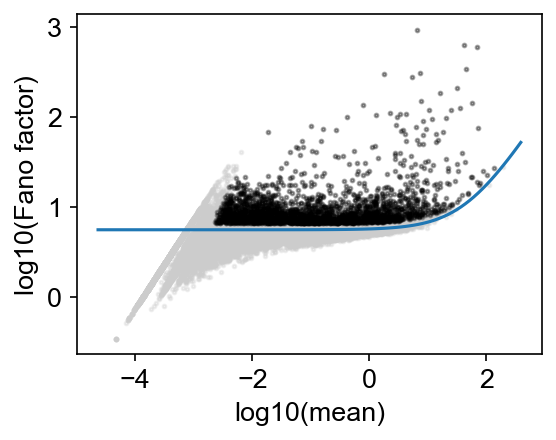

Keeping 2489 genes


In [8]:
cs.pp.get_highly_variable_genes(adata_orig,normalized_counts_per_cell=10000,min_counts=3, 
        min_cells=3, min_gene_vscore_pctl=85)

Compute for each gene its correlation with a set of cell cycle genes. There is a default cell cycle gene set for mouse.
You might need to use your own genes. This step is optional, but recommended. 

adata.var['highly_variable'] not updated.
Please choose corr_threshold properly, and set confirm_change=True


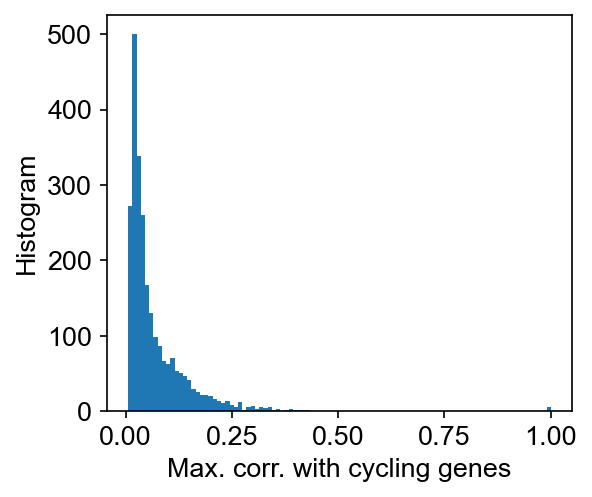

In [9]:
cs.pp.remove_cell_cycle_correlated_genes(adata_orig)

Now, actually confirm the change at a specific cutoff threshold. 

In [10]:
cs.pp.remove_cell_cycle_correlated_genes(adata_orig,corr_threshold=0.1,confirm_change=True)

Number of selected non-cycling highly variable genes: 1958
Remove 531 cell cycle correlated genes.
adata.var['highly_variable'] updated


Compute the `X_pca`, `X_emb`, and `state_info` (from clustering). `X_pca` will be used to build the similarity matrix later. `X_emb` is only used for visualization. You can also pass your favoriate embedding directly to 
`adata.obsm['X_emb']`.

In [11]:
update=False
if update:
    cs.pp.get_X_pca(adata_orig,n_pca_comp=40) 
    #cs.pp.get_X_emb(adata_orig,n_neighbors=20,umap_min_dist=0.3) #Do not run this, as we want to keep the original embedding
    #cs.pp.get_state_info(adata_orig,n_neighbors=20,resolution=0.5) # Do not run this, as we want to keep the original state annotation.

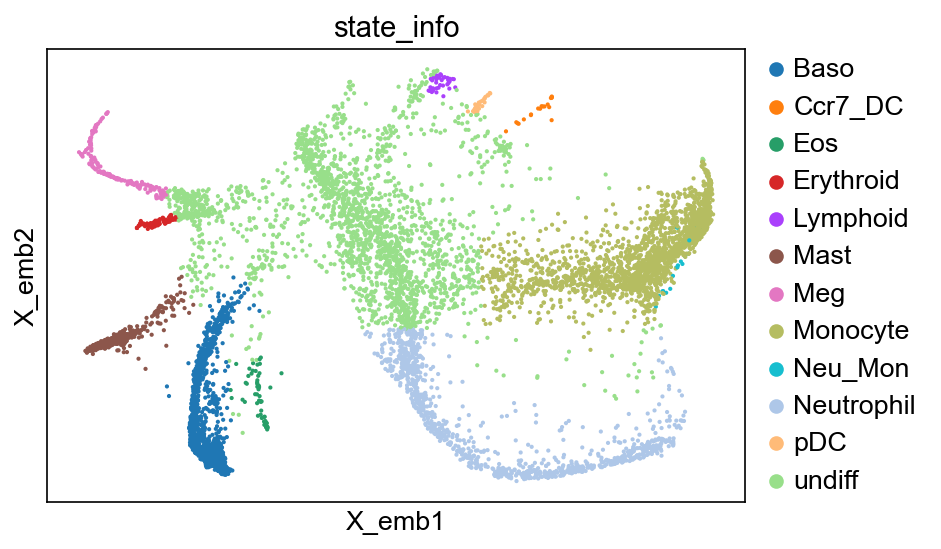

In [12]:
cs.pl.embedding(adata_orig,color='state_info')

In [13]:
cs.hf.check_available_choices(adata_orig)

Available transition maps: []
Availabel clusters: ['Neu_Mon', 'Eos', 'Ccr7_DC', 'Meg', 'Mast', 'pDC', 'Lymphoid', 'Erythroid', 'Baso', 'undiff', 'Neutrophil', 'Monocyte']
Availabel time points: ['2', '6', '4']
Clonal time points: ['2', '6', '4']


You can choose to save preprocessed data. It can be loaded using `cs.hf.read(file_name)`. 

In [14]:
save=False
if save:
    cs.hf.save_preprocessed_adata(adata_orig)

### Raw clonal data analysis

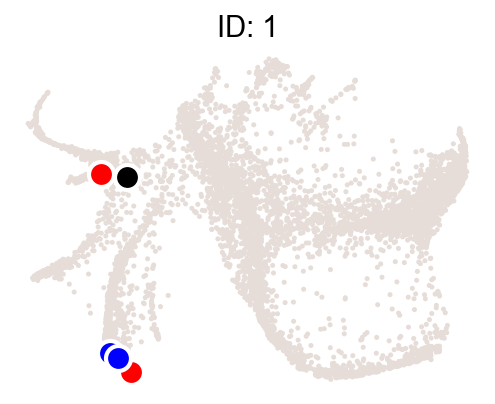

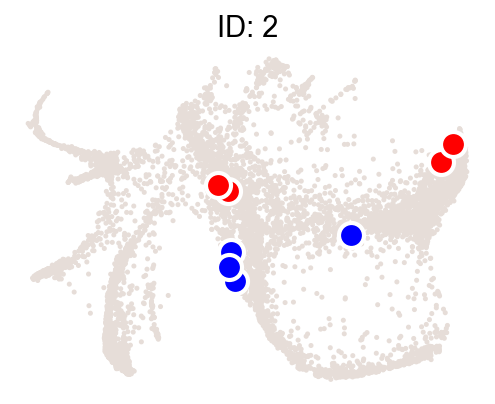

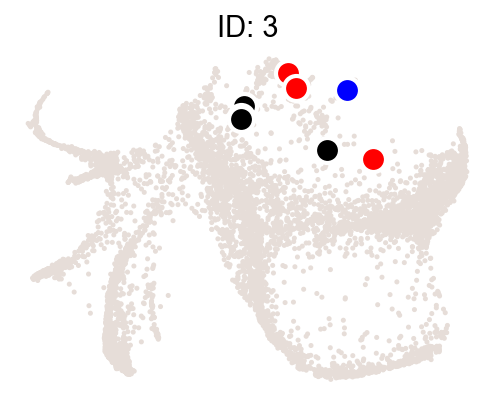

In [15]:
cs.pl.clones_on_manifold(adata_orig,selected_clone_list=[1,2,3],color_list=['black','red','blue'],point_size=2)

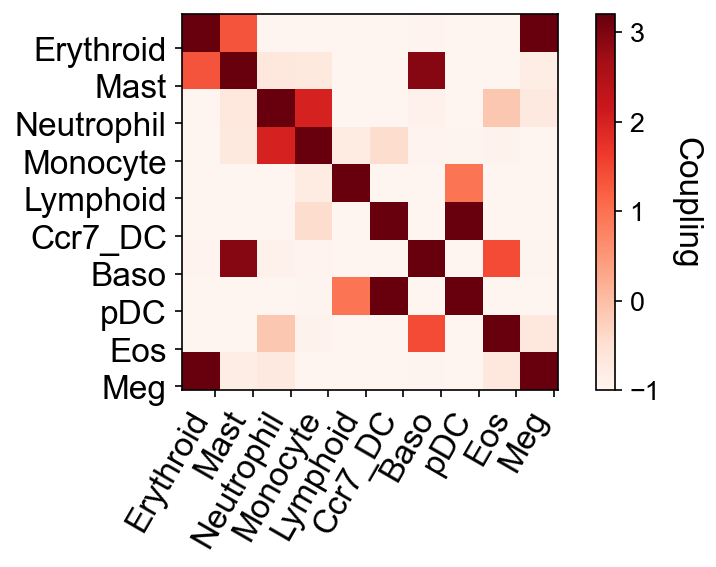

In [16]:
selected_time_point='4'
selected_fates=['Erythroid', 'Mast', 'Neutrophil', 'Monocyte', 'Lymphoid', 'Ccr7_DC', 'Baso',  'pDC', 'Eos', 'Meg']
cs.pl.fate_coupling_from_clones(adata_orig,selected_time_point, selected_fates=selected_fates, color_bar=True)

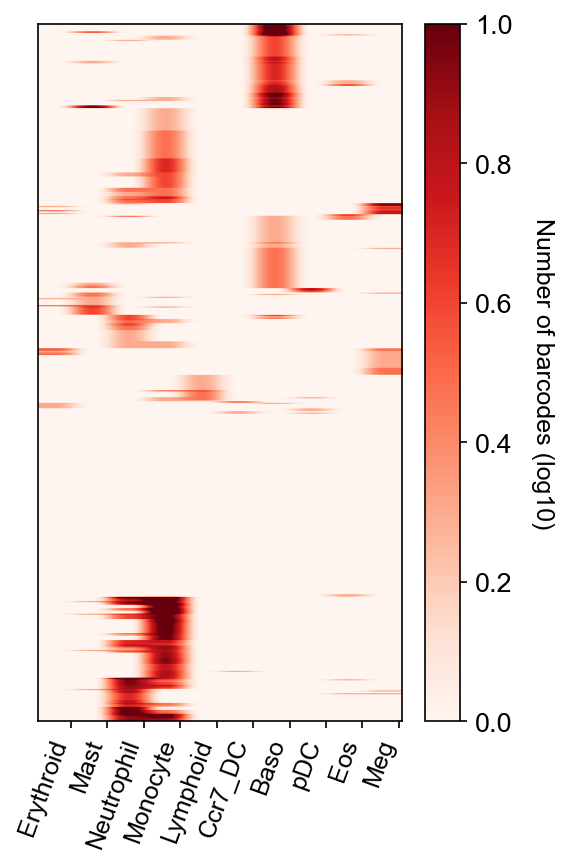

In [17]:
selected_time_point='4'
cs.pl.barcode_heatmap(adata_orig,selected_time_point, selected_fates=selected_fates, color_bar=True)

This step is slow and optional. The time is linearly proportional to the multiplication of clone number and N_resampling. It takes half a minute for the given parameters. To gain stronger statistical power, increase `N_resampling`.

Current clone id: 0
Current clone id: 50
Current clone id: 100
Current clone id: 150
Current clone id: 200
Current clone id: 250
Current clone id: 300
Current clone id: 350
Current clone id: 400
Current clone id: 450


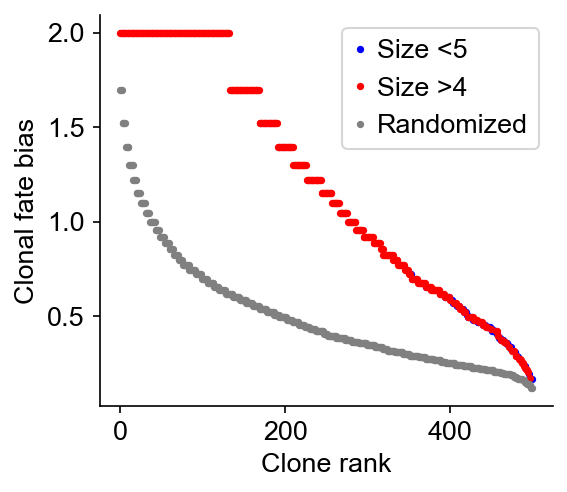

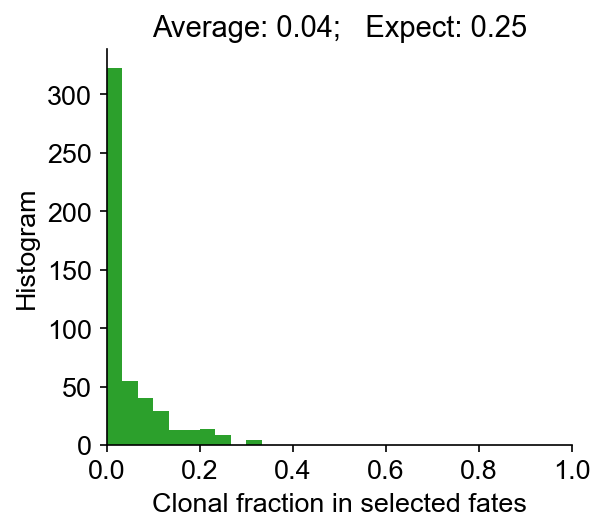

In [18]:
clonal_fate_bias,clone_id=cs.pl.clonal_fate_bias(adata_orig,selected_fate='Monocyte',
            clone_size_thresh=5,N_resampling=100,compute_new=False)

## Transition map inference

As mentioned in **Getting Started**, there are several methods for map inference. Below, we illustrate the one that uses multiple clonal time points and integrates state and clonal information. The first time it runs, it will compute the similarity matrix at different smooth rounds and save them. Then, it will infer the transition map. It takes 2 mins to run for the first time, and 11 s for later runs. Some key parameters:
    
* **smooth_array**: a list of numbers defining the smooth rounds at each iteration of coherent sparsity optimization. Its length determines the number of iteration. We found that 3 iteration rounds are generally sufficient. We recommend using descending smooth rounds to mimic simulated annealing. It is better to use a number at the multiple of 5, i.e., 5, 10, 15, 20,…
    
* **noise_threshold**: noise threshold to remove spurious transitions in the updated transition map, in the range [0,1].

-------Step 1: Select time points---------
--> Clonal cell fraction (day 2-4): 1.0
--> Clonal cell fraction (day 4-6): 1.0
--> Clonal cell fraction (day 4-2): 0.3892466194462331
--> Clonal cell fraction (day 6-4): 1.0
--> Numer of cells that are clonally related -- day 2: 286  and day 4: 1209
--> Numer of cells that are clonally related -- day 4: 3106  and day 6: 4046
Valid clone number 'FOR' post selection 500
Cell number=7438, Clone number=500
-------Step 2: Compute the full Similarity matrix if necessary---------
Compute similarity matrix: computing new; beta=0.1
Smooth round: 1
--> Time elapsed: 0.022039175033569336
Smooth round: 2
--> Time elapsed: 0.12040495872497559
Smooth round: 3
--> Time elapsed: 0.44730591773986816
--> Orignal sparsity=0.11405884956222492, Thresholding
--> Final sparsity=0.07885019703258508
similarity matrix truncated (Smooth round=3):  0.5379300117492676
Smooth round: 4
--> Time elapsed: 0.9099929332733154
--> Orignal sparsity=0.18045154273806427, Threshold

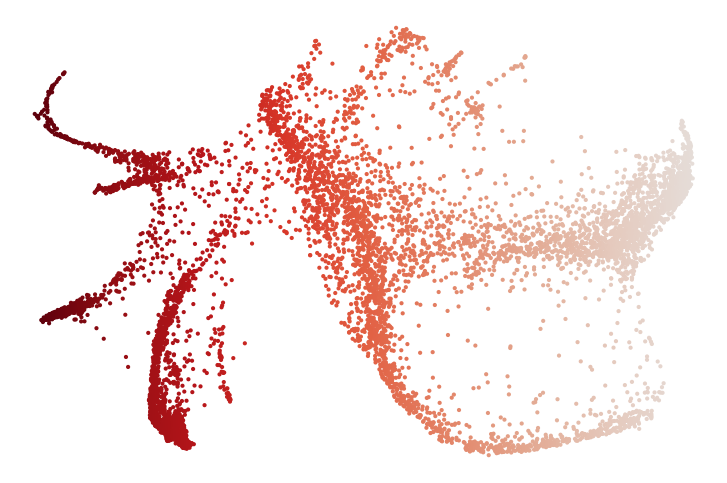

In [19]:
noise_threshold=0.2 # 
selected_clonal_time_points=['2','4','6']
adata=cs.tmap.infer_Tmap_from_multitime_clones(adata_orig,selected_clonal_time_points,smooth_array=[20,15,10],
        noise_threshold=noise_threshold,demulti_threshold=noise_threshold,use_full_Smatrix=True)

We can see that after this step, we have two maps: `'transition_map'` and `'intraclone_transition_map'`. Both of them can be used 
    for downstream analysis. 

In [20]:
cs.hf.check_available_choices(adata)

Available transition maps: ['transition_map', 'intraclone_transition_map']
Availabel clusters: ['Neu_Mon', 'Eos', 'Ccr7_DC', 'Meg', 'Mast', 'pDC', 'Lymphoid', 'Erythroid', 'Baso', 'undiff', 'Neutrophil', 'Monocyte']
Availabel time points: ['2', '6', '4']
Clonal time points: ['2', '6', '4']


## Save or load pre-computed data

This can be used to save adata with maps computed from different tools or parameters.
Usually, different parameter choices will result in different `data_des`, a prefix to identify the anndata.
Saving an adata would print the `data_des`, which can be used to load the corresponding adata.

In [21]:
save_data=False
if save_data:
    cs.hf.save_map(adata)
    
load_data=False
if load_data:
    # updated Jan 27, 2021
    #data_des='blood_TwoTimeClone_t*4*6'
    #data_des='blood_TwoTimeClone_t*2*4*6'
    adata=cs.hf.load_saved_adata_with_key(data_des)

## Plotting

There are some common parameters:

* `used_map_name` (str). It determines which transition map to use for analysis. Choices: {‘transition_map’, ‘intraclone_transition_map’, ‘OT_transition_map’, ‘HighVar_transition_map’,’clonal_transition_map’}

* `selected_fates` (list of str). Selected clusters to aggregate differentiation dynamics and visualize fate bias etc.. It allows nested structure, e.g., selected_fates=[‘a’, [‘b’, ‘c’]] selects two clusters: cluster ‘a’ and the other that combines ‘b’ and ‘c’.

* `map_backwards` (bool). We can analyze either the forward transitions, i.e., where the selected states or clusters are going (map_backwards=False), or the backward transitions, i.e., where these selected states or clusters came from (map_backwards=True). The latter is more useful, and is the default.

* `selected_time_points` (list). List of time points to use. By default, all are used. 

### Transition profiles for single cells

First, check the forward transitions (i.e., future states) from the `'transition_map'`.

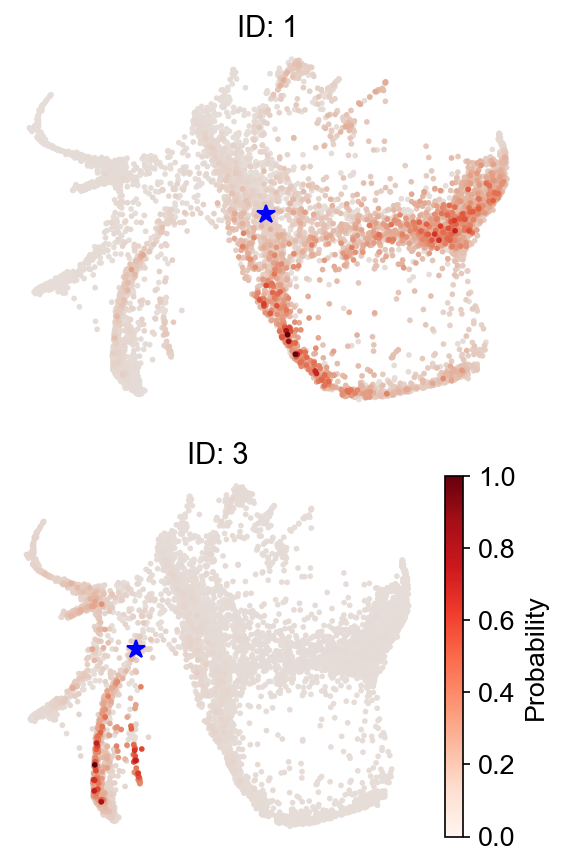

In [22]:
selected_state_id_list=[1,3] # This is a relative ID. Its mapping to the actual cell id depends on map_backwards.

map_backwards=False
cs.pl.single_cell_transition(adata,selected_state_id_list=selected_state_id_list,
                                    used_map_name='transition_map',map_backwards=map_backwards)

Now, backward transitions (i.e., past states) from the same map.

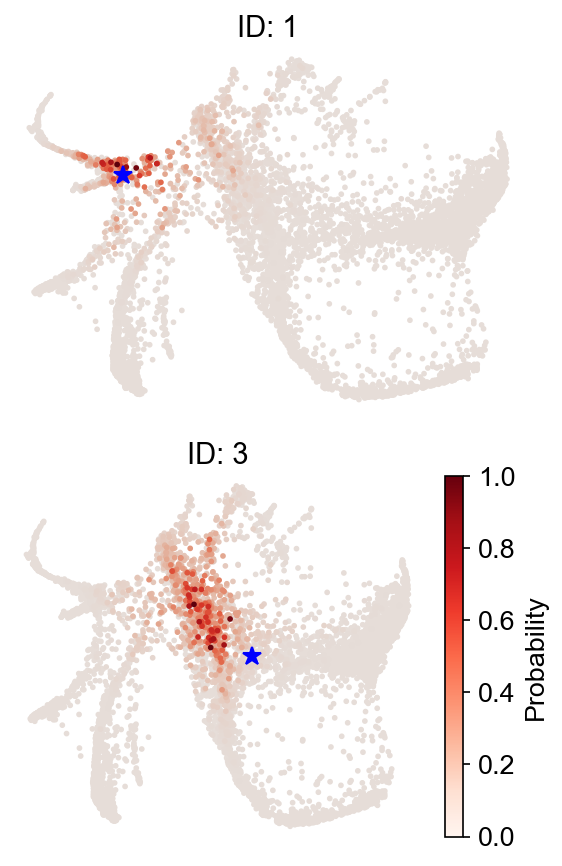

In [23]:
selected_state_id_list=[1,3]
map_backwards=True
cs.pl.single_cell_transition(adata,selected_state_id_list=selected_state_id_list,
                                    used_map_name='transition_map',map_backwards=map_backwards)

Finally, switch to the `'intraclone_transition_map'`, and check backward transitions. We can see that the second id does not have corresponding clonally related initial states.

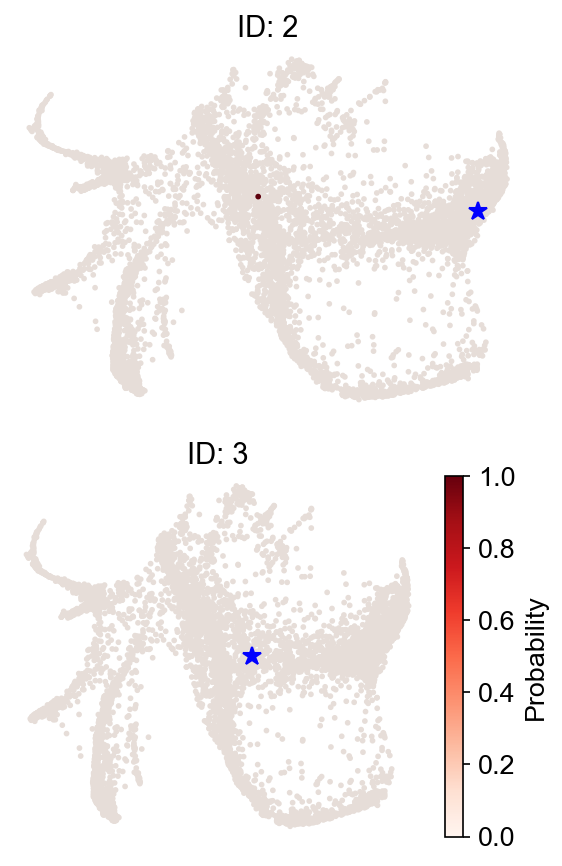

In [24]:
selected_state_id_list=[2,3] 
map_backwards=True
cs.pl.single_cell_transition(adata,selected_state_id_list=selected_state_id_list,
                                    used_map_name='intraclone_transition_map',map_backwards=map_backwards)

### Fate map

Inspect the backward transitions, and ask where the selected fate clusters are at the previous time point.

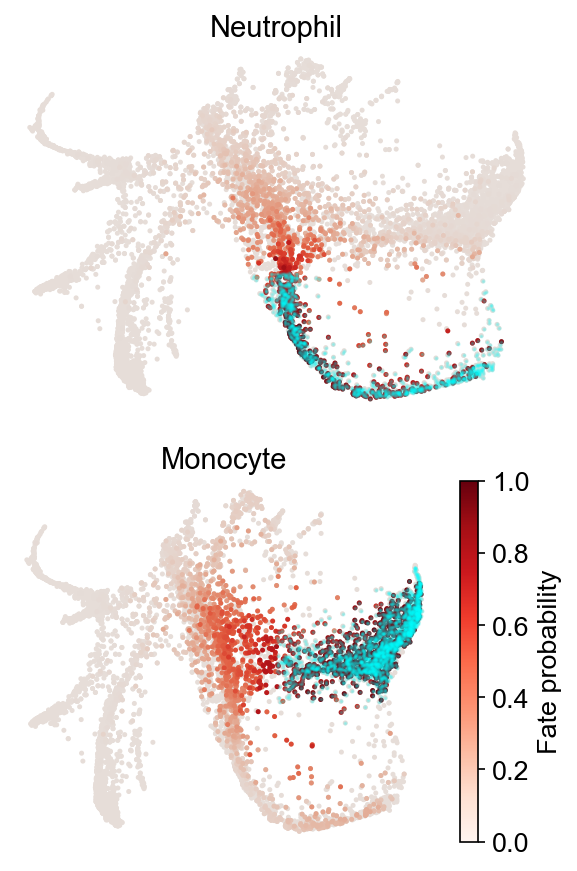

In [25]:
cs.pl.fate_map(adata,selected_fates=['Neutrophil','Monocyte'],
               used_map_name='transition_map',map_backwards=True,plot_target_state=True)

Now, do the same thing with `'intraclone_transition_map'`.

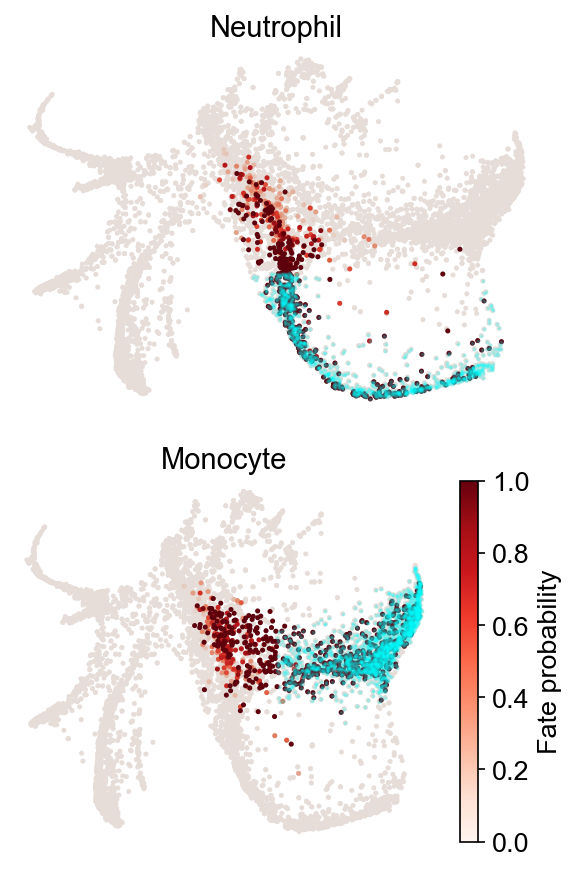

In [26]:
cs.pl.fate_map(adata,selected_fates=['Neutrophil','Monocyte'],
               used_map_name='intraclone_transition_map',map_backwards=True,plot_target_state=True)

As a comparison, if we use only the clonal information to construct the transition map, this is what it looks like:

Use only uni-potent clones (weinreb method)
Used uni-potent clone fraction 0.472


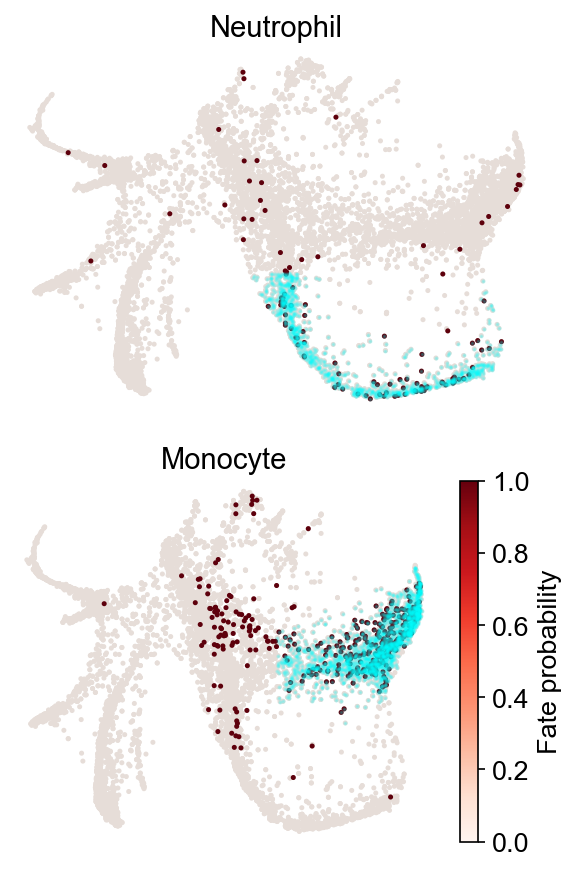

In [27]:
cs.tmap.infer_Tmap_from_clonal_info_alone(adata,method='weinreb')

cs.pl.fate_map(adata,selected_fates=['Neutrophil','Monocyte'],
               used_map_name='clonal_transition_map',map_backwards=True,plot_target_state=True)

### Relative fate bias

First, check the intrinsic fate bias of initial states towards a cluster, which is the predicted fate map normalized by the expected fate probability. The null expectation is the fraction of cells in this cluster at the corresponding time point. A state has an intrinsic fate bias for each fate cluster. 

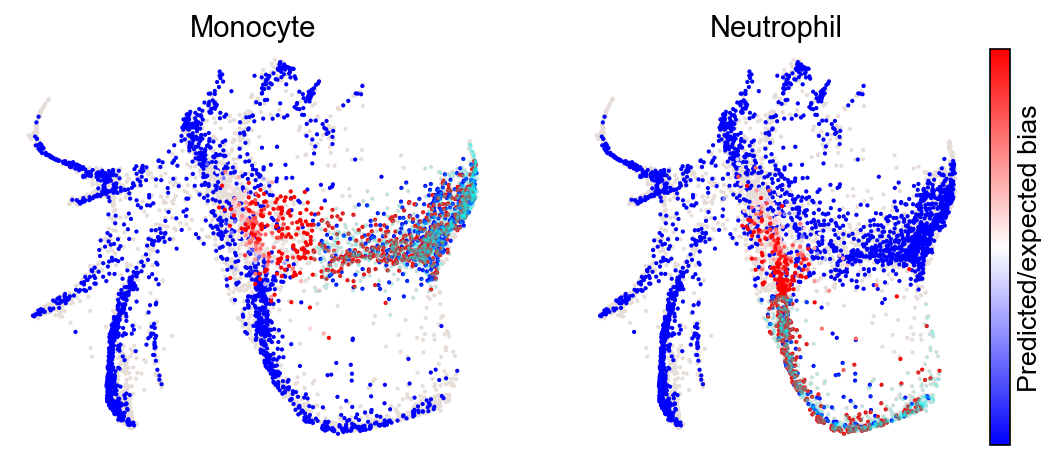

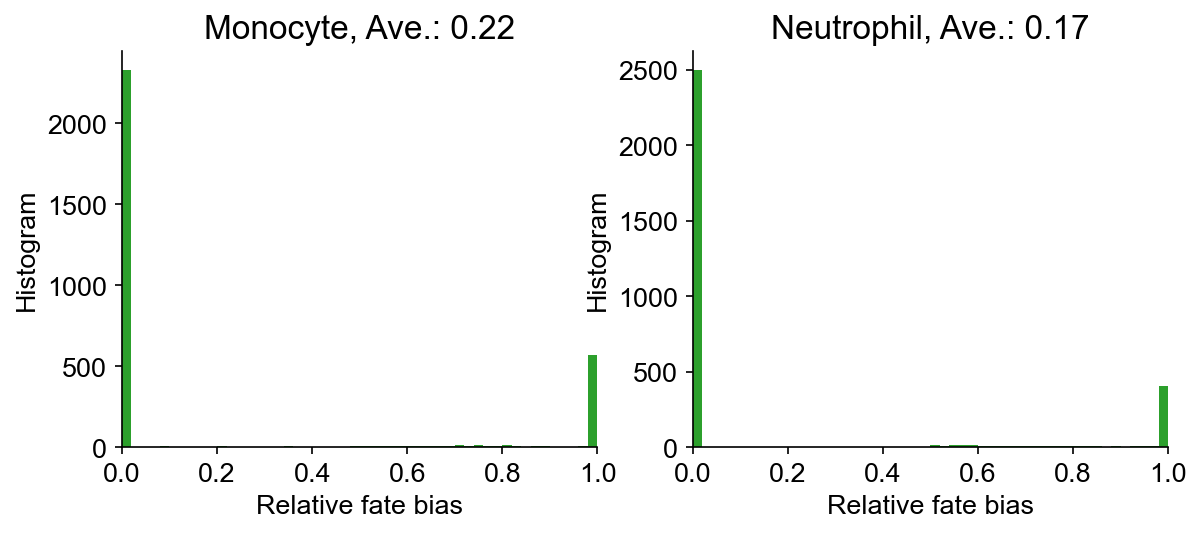

In [28]:
cs.pl.fate_bias_intrinsic(adata,selected_fates=['Monocyte','Neutrophil'],used_map_name='intraclone_transition_map',
            selected_time_points=['4'],plot_target_state=True,map_backwards=True)

Next, check the fate bias of initial states defined by competition between two fate clusters A and B, i.e., how strongly A is favored than B. Only states with fate probabilities satisfying this criterion will be shown: 

* P(A)+P(B)>sum_fate_prob_thresh

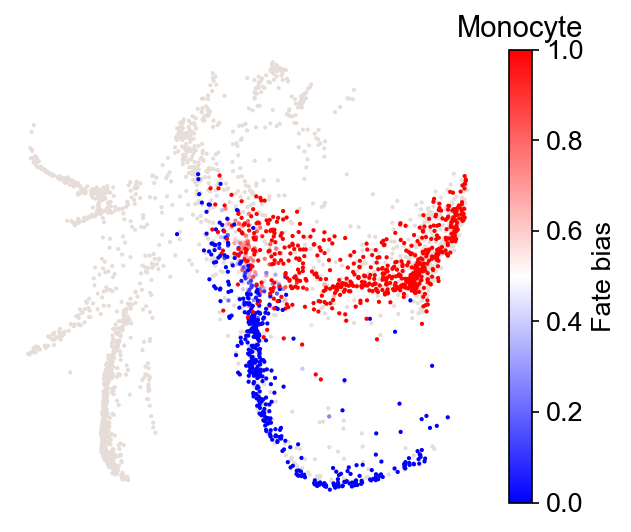

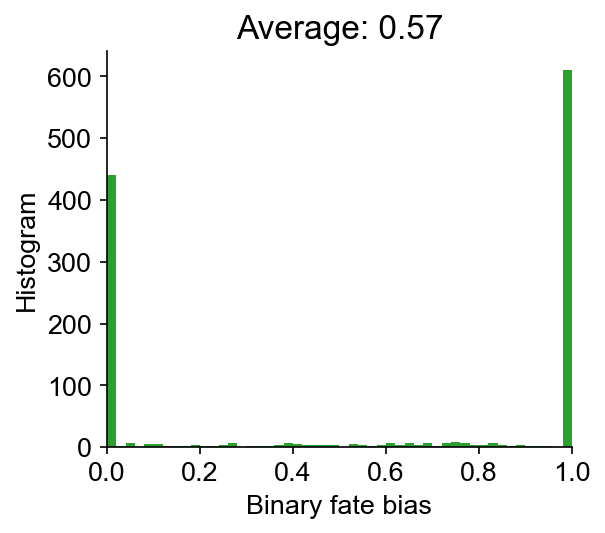

In [29]:
cs.pl.fate_bias_from_binary_competition(adata,selected_fates=['Monocyte','Neutrophil'],used_map_name='intraclone_transition_map',
            selected_time_points=['4'],plot_target_state=False,map_backwards=True,sum_fate_prob_thresh=0.1)

### Dynamic trajectory inference

One way to define the dynamic trajectory is simply mapping a given fate cluster backward in time. The whole trajectory across
multiple time points will be saved at `adata.uns['dynamic_trajectory']`. This method performs best if there are multiple clonal time points. 

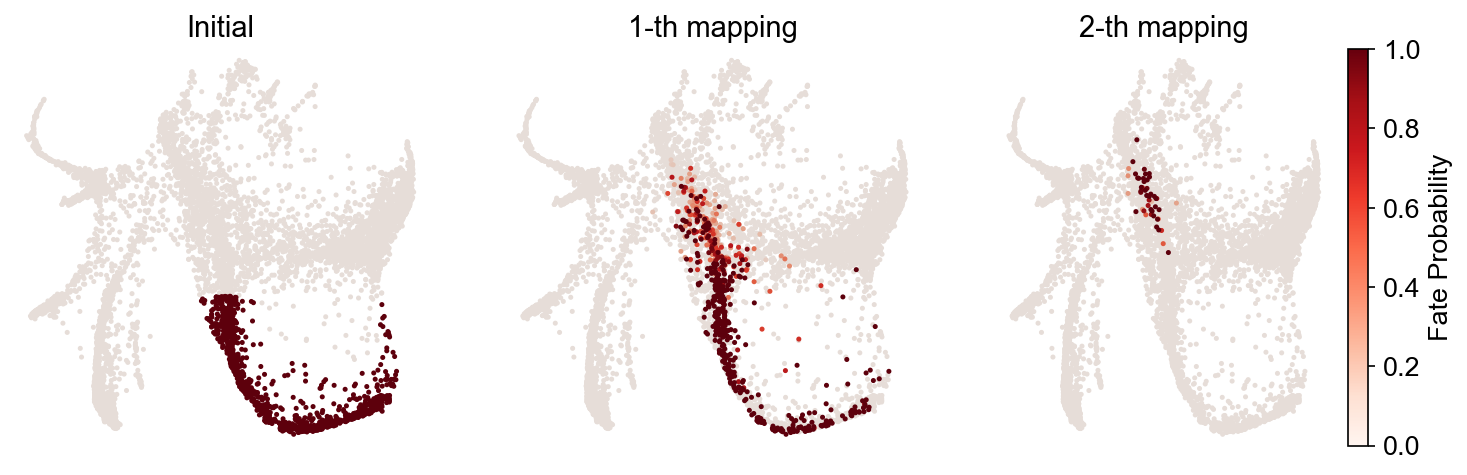

In [30]:
cs.pl.dynamic_trajectory_via_iterative_mapping(adata,selected_fate='Neutrophil',plot_separately=True,used_map_name='intraclone_transition_map')

In the second approach, we use the intrinsic fate bias to define the dynamic trajectory and also the ancestor population. It requires the input of two selected fates A and B.  States with a bias for A higher than `bias_threshold_A` will be selected as ancestor states for fate A; `bias_threshold_B` similarly controls trajectory selection for fate B. The selected cell states will be stored at `adata.uns['cell_group_A']` and `adata.uns['cell_group_B']`. The selected states along with the corresponding fate cluster will be stored at `adata.uns['dynamic_trajectory']` for inspecting dynamic gene expression. Setting avoid_target_states=True will remove ancestor states already inside the given fate cluster.

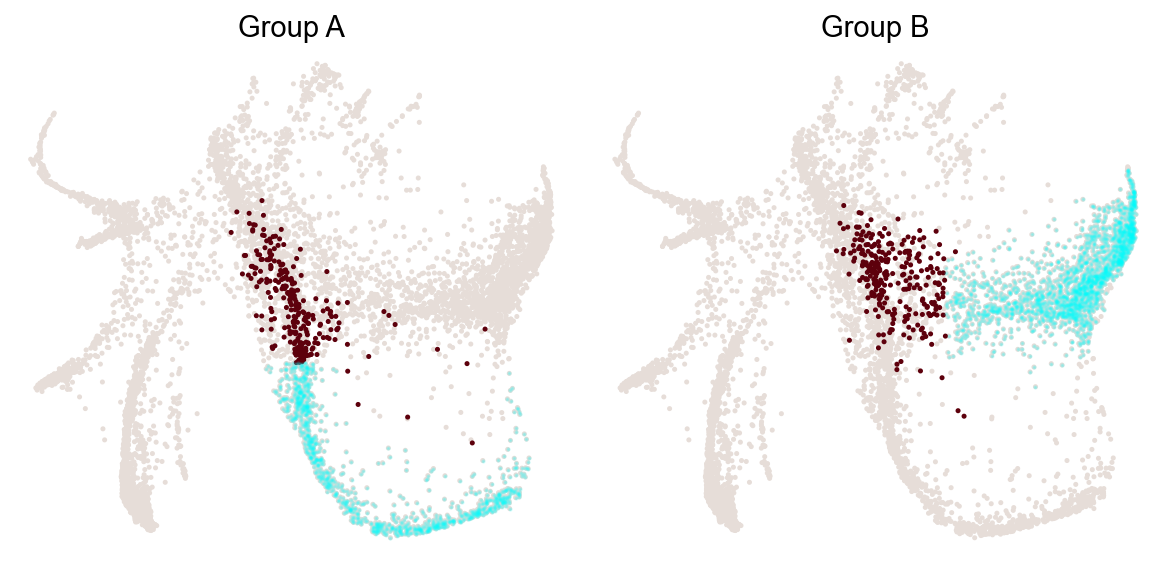

In [31]:
cs.pl.dynamic_trajectory_from_intrinsic_bias(adata, selected_fates=['Neutrophil','Monocyte'], 
 used_map_name='intraclone_transition_map', map_backwards=True, bias_threshold_A=0.6, 
                                        bias_threshold_B=0.6, avoid_target_states=True)


We can also infer the dynamic trajectory and ancestor population using the fate bias from binary fate competition. Here, fate bias is a scalar between (0,1) at each state. Selected ancestor population satisfies:

   * Prob(A)+Prob(B)>sum_fate_prob_thresh; 

   * Ancestor states for A: Bias>0.5+bias_threshold

   * Ancestor states for B: bias<0.5+bias_threshold

They will be stored at `adata.uns['cell_group_A']` and `adata.uns['cell_group_B']`. The selected states along with the corresponding fate cluster will be stored at `adata.uns['dynamic_trajectory']` for inspecting dynamic gene expression. 

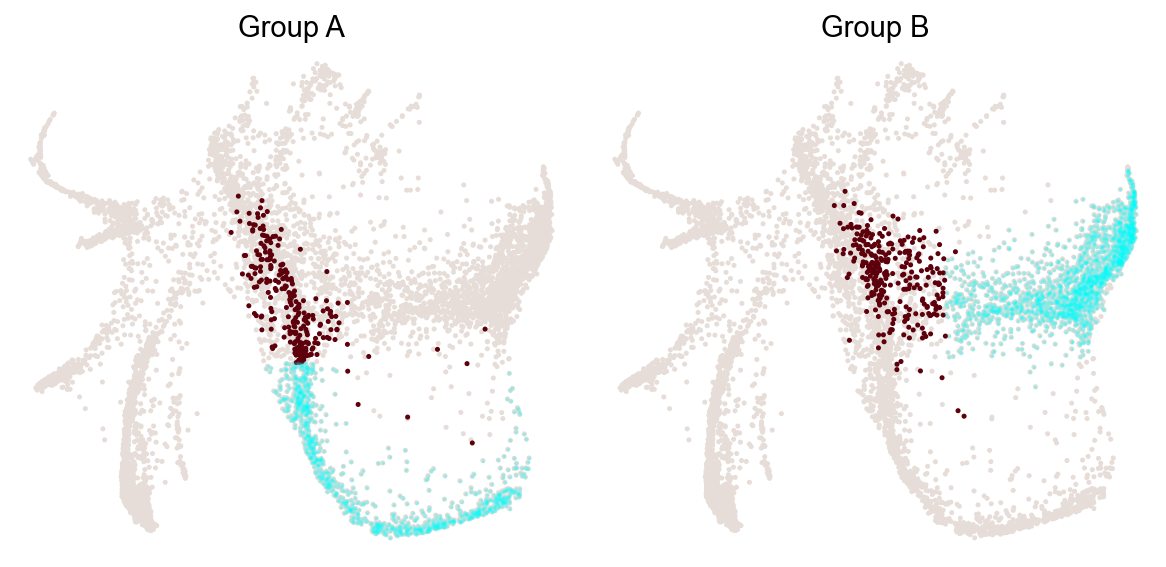

In [32]:
cs.pl.dynamic_trajectory_from_competition_bias(adata, selected_fates=['Neutrophil','Monocyte'], 
 used_map_name='intraclone_transition_map', map_backwards=True, 
    bias_threshold=0, sum_fate_prob_thresh=0.2, avoid_target_states=True)

### Differential genes for two ancestor groups

It would be interesting to see what genes are differentially expressed between these two ancestor populations, which might drive the fate bifurcation. The two population can be accessed at `adata.obs['cell_group_A']` and `adata.obs['cell_group_B']`. We provide a simple differentiation gene expression analysis that uses Wilcoxon rank-sum test to calculate P values, followed by Benjamini-Hochberg correction. You can always use your method.

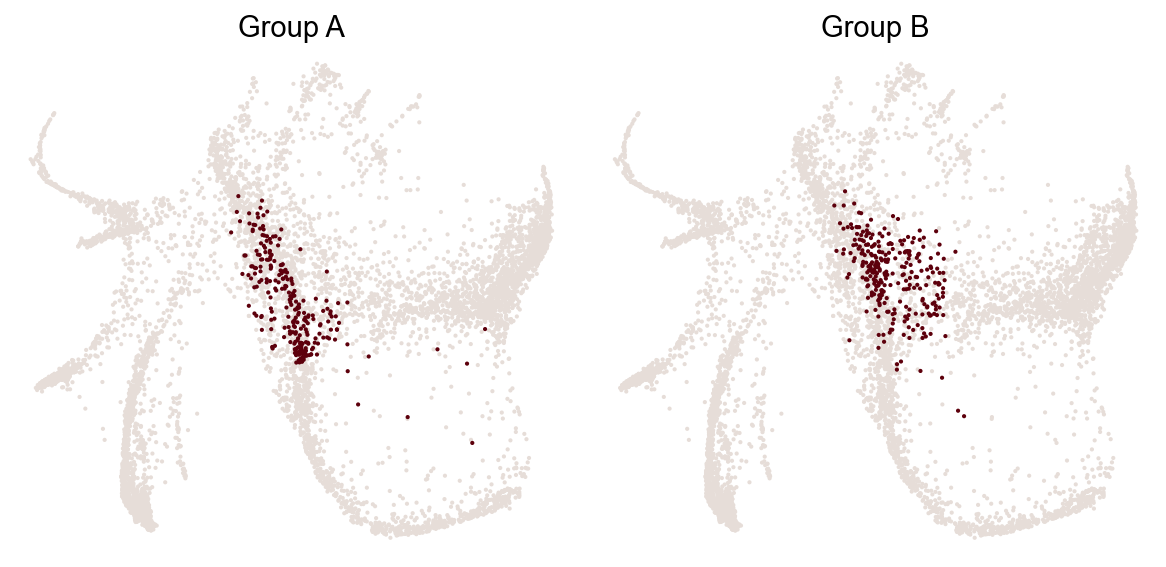

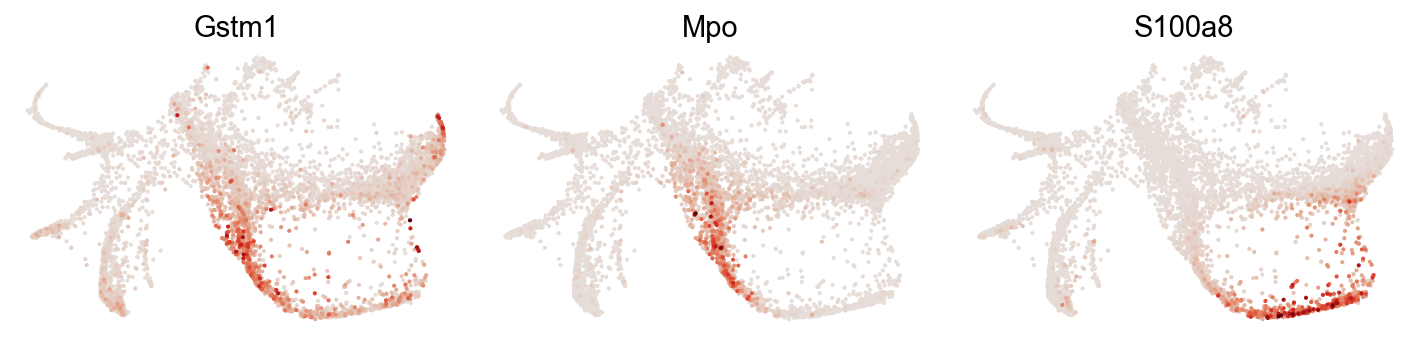

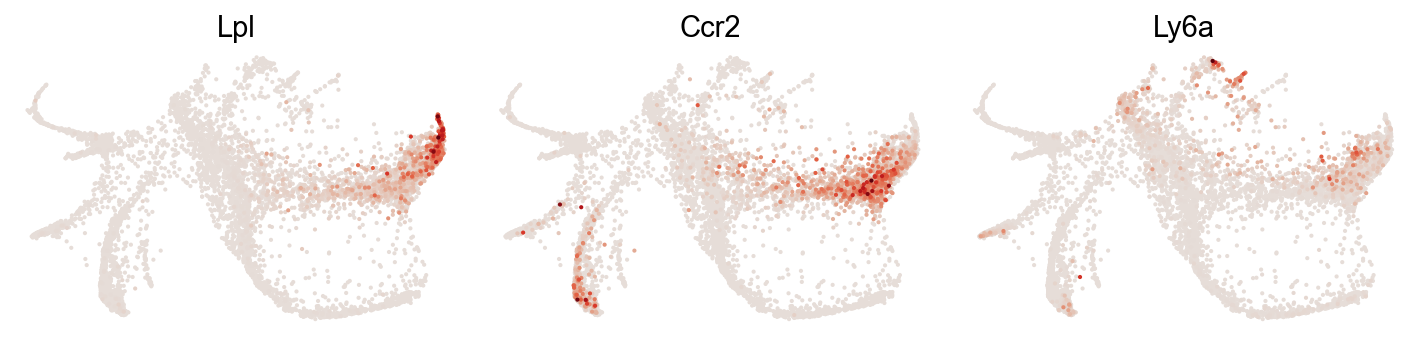

In [33]:
# This step requires that adata.obs['cell_group_A'] and adata.obs['cell_group_B'] exist.
dge_gene_A, dge_gene_B=cs.pl.differential_genes(adata,plot_gene_N=3)

### Gene trend along the dynamic trajectory

Any one of the 3 dynamic trajectory inference methods will save the trajectory at
`adata.uns['dynamic_trajectory']`. We can calculate the pseudotime along this trajectory
and plot the gene expression along this pseudo time. This method requires that `adata.uns['dynamic_trajectory']` exists, and the selected fate is in the pre-computed list.

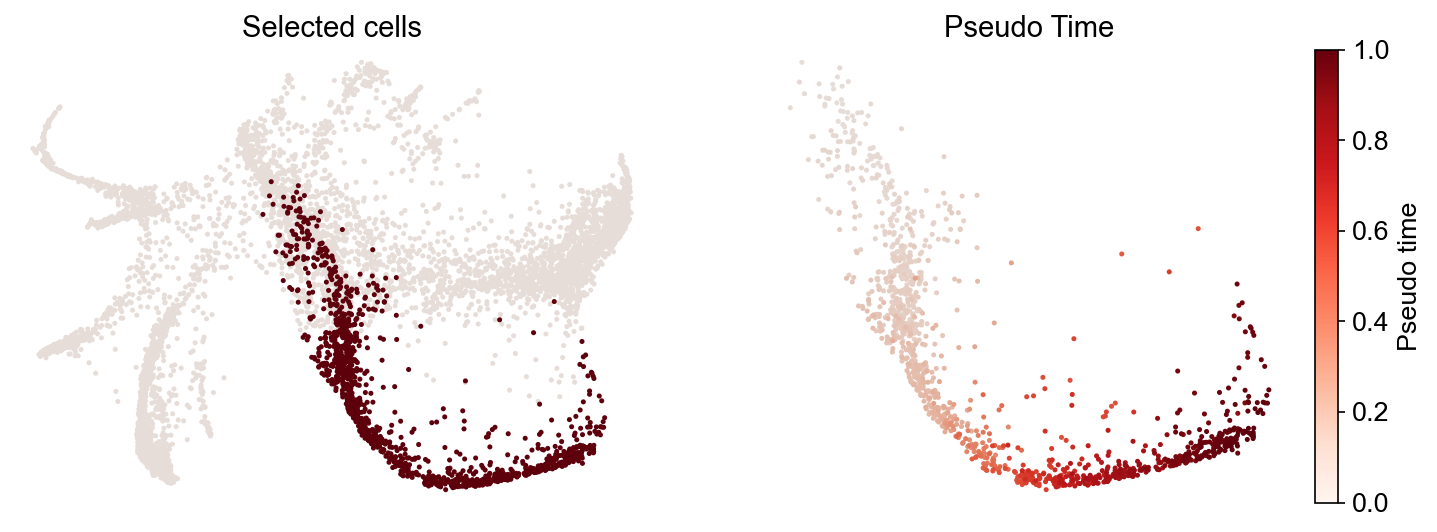

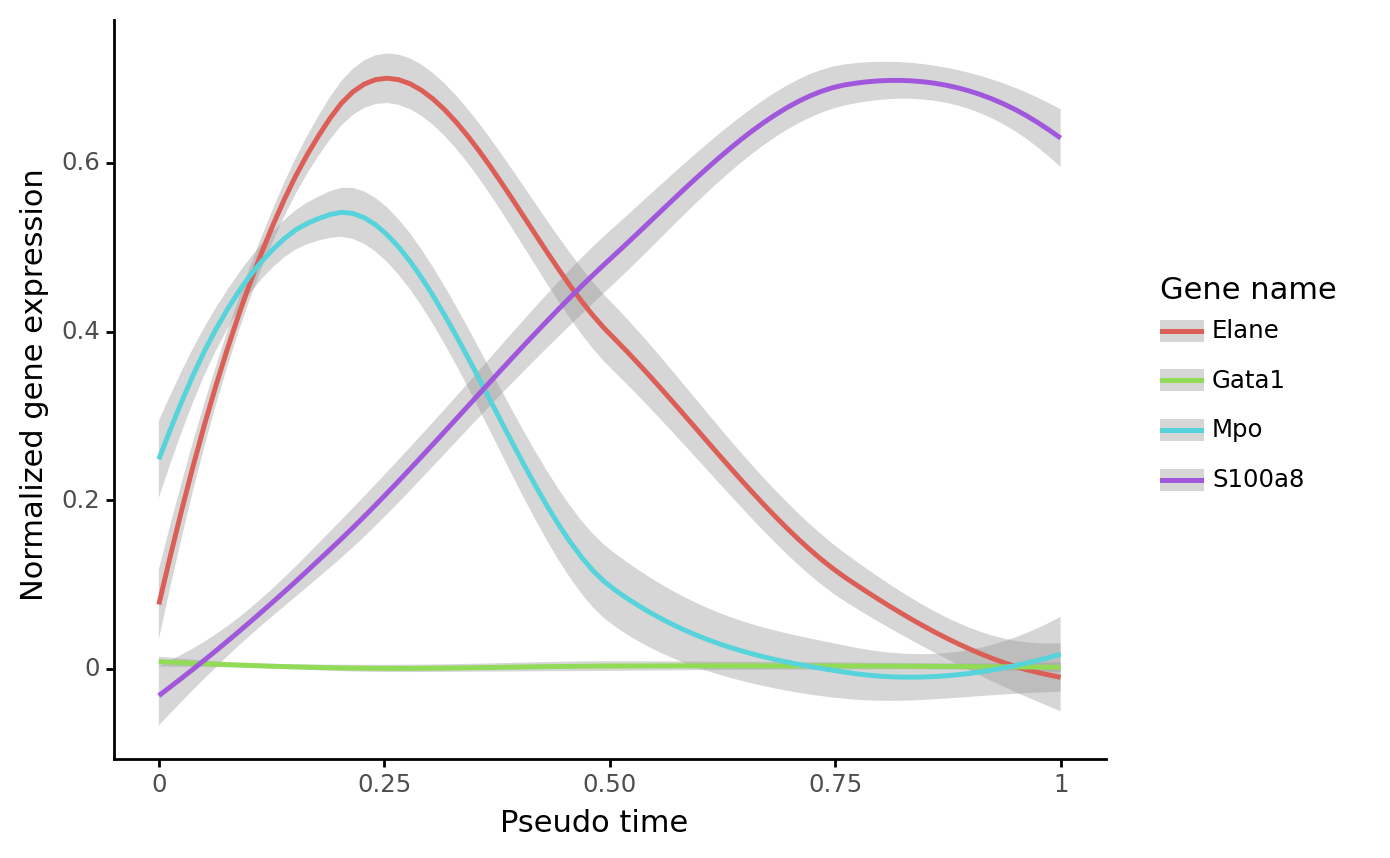

In [34]:
gene_name_list=['Gata1','Mpo', 'Elane', 'S100a8']
selected_fate='Neutrophil'
adata_selected=cs.pl.gene_expression_dynamics(adata,selected_fate,gene_name_list, traj_threshold=0.2,  
      map_backwards=True, invert_PseudoTime=False, include_target_states=True, compute_new=True, 
    fig_width=3.5, gene_exp_percentile=99, n_neighbors=8, plot_raw_data=False, point_size=2)

The method outputs a new adata object with the selected cell states. This can be used to run your favoriate pseudotime analysis methods.

Trying to set attribute `.uns` of view, copying.


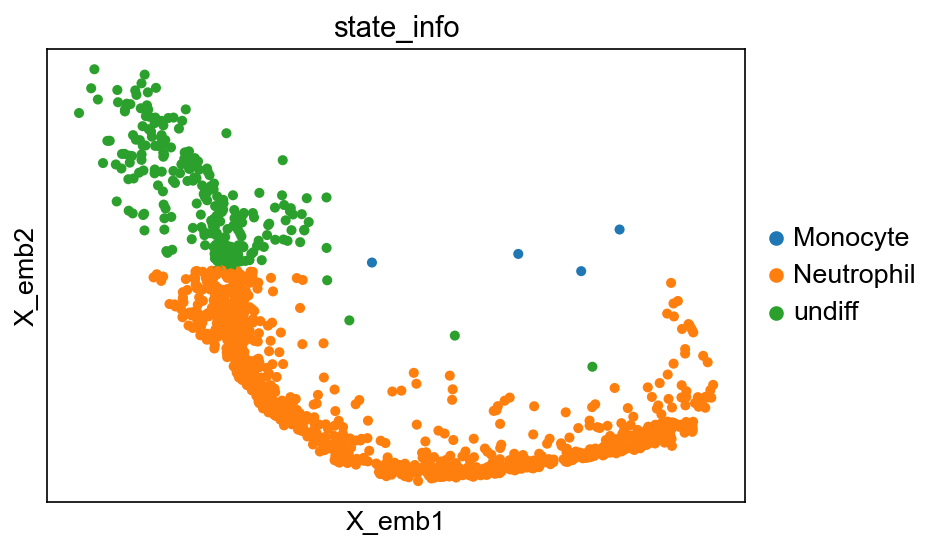

In [35]:
cs.pl.embedding(adata_selected,color='state_info')

### Fate coupling of the transition map

The inferred transition map can be used to estimate differentiation coupling between different fate clusters. 

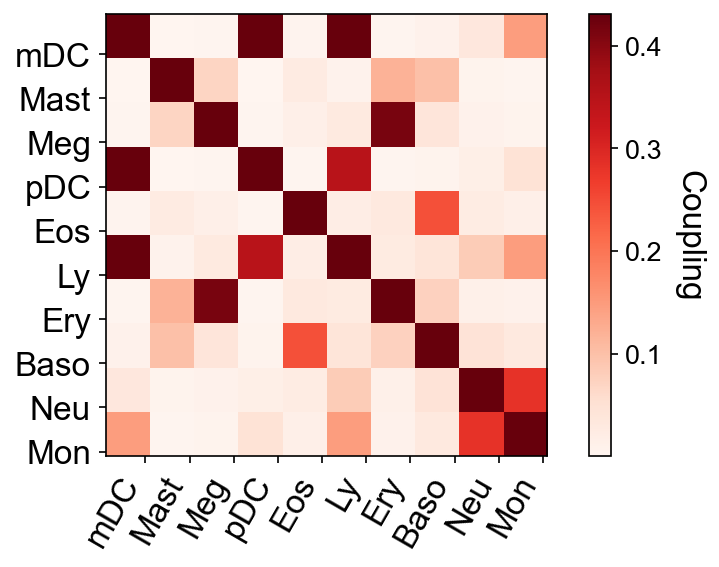

In [36]:
fate_array=['Ccr7_DC','Mast','Meg','pDC','Eos','Lymphoid','Erythroid','Baso',  'Neutrophil', 'Monocyte']
celltype_names=['mDC',  'Mast', 'Meg', 'pDC', 'Eos', 'Ly', 'Ery', 'Baso', 'Neu', 'Mon']
cs.pl.fate_coupling_from_Tmap(adata,selected_fates=fate_array,used_map_name='transition_map',
                        rename_selected_fates=celltype_names)


## Miscellaneous

### Transition map from state information and the last clonal time point

After initializing the map by either *OT* method or *HighVar* method, We jointly infer the likely clonal ancestors and the transition map between cell states across given time points. You need to choose the initialization method and set the corresponding parameters.

* `OT`: optional transport based method. It tends to be more accurate than `HighVar`, but not reliable under batch differences between time points. Key parameters: 
        
    * `OT_epsilon` for the entropic regularization 
    
    * `OT_cost`: {'GED', 'SPD'}, method for computing the cost function. 'GED' uses simple gene expression distances; it is faster. 'SPD' uses the shortest path distances; it is slower but more accurate. 

* `HighVar`: a method that converts highly variable genes into pseudo clones and run coherent sparsity optimization to generate an initialized map. Although it is not as accurate as `OT`, it is robust to batch effect across time points and is used to analyze the lung dataset.  
    
    * `HighVar_gene_pctl`: percentile threshold to select highly variable genes. Range: [0,100]. A higher value selects more variable genes. 

Let us try the OT method that uses gene expression distances. It takes around 1 min to run.

In [37]:
initial_time_points=['4'] #['2','4']
clonal_time_point='6'
adata=cs.tmap.infer_Tmap_from_one_time_clones(adata_orig,initial_time_points,clonal_time_point,Clone_update_iter_N=1,
        initialize_method='OT',OT_cost='GED',smooth_array=[20,15,10],noise_threshold=0.2,use_full_Smatrix=True)

-------------------------------New Start--------------------------------------------------
Current time point: 4
-----------Pre-processing and sub-sampling cells------------
----------------
Step 1: Use OT method for initialization
Finishing computing gene expression distance, used time 5.09515905380249
Compute new custon OT matrix
OT solver: duality_gap
Finishing computing optial transport map, used time 34.327800273895264
----------------
Step 2: Jointly optimize the transition map and the initial clonal states!
Joint optimization that consider possibility of clonal overlap: v2
--> original clone shape: (7152, 500)
--> After excluding zero-sized clones at t2: (7152, 500)
Sort clones by size (small to large)
Infer the number of initial cells to extract for each clone in advance
--> Inferring early clonal states: current clone id 0
--> Inferring early clonal states: current clone id 100
--> Inferring early clonal states: current clone id 200
--> Inferring early clonal states: current c

Now, check the result of the initialized map `OT_transition_map`. 

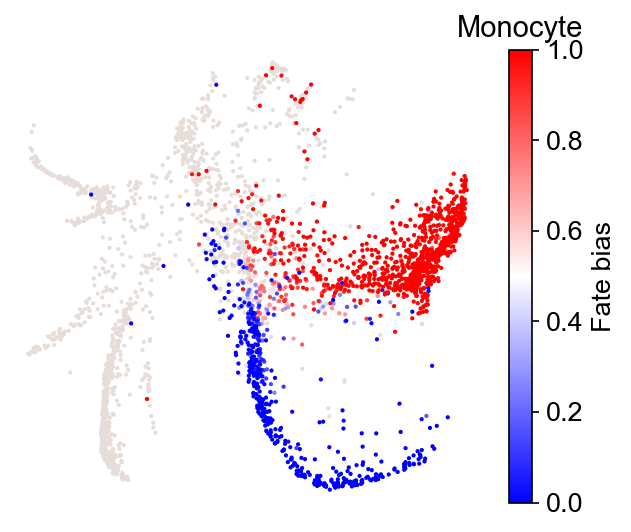

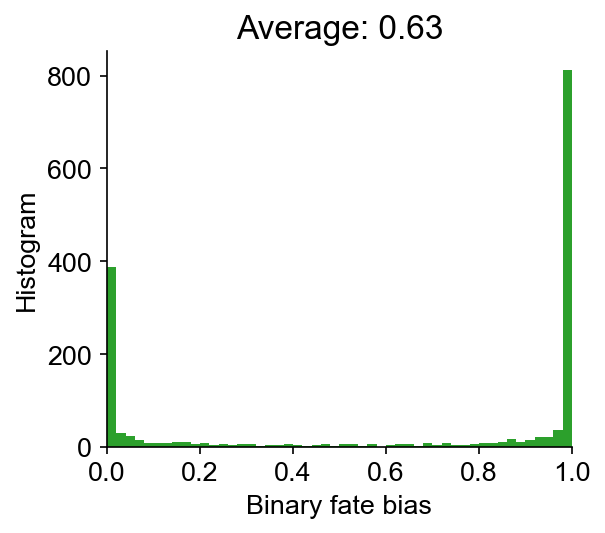

In [38]:
cs.pl.fate_bias_from_binary_competition(adata,selected_fates=['Monocyte','Neutrophil'],
    used_map_name='OT_transition_map',selected_time_points=['4'],plot_target_state=False,
                                map_backwards=True,sum_fate_prob_thresh=0.1)

After joint optimization, the final result of the transition map is much better:

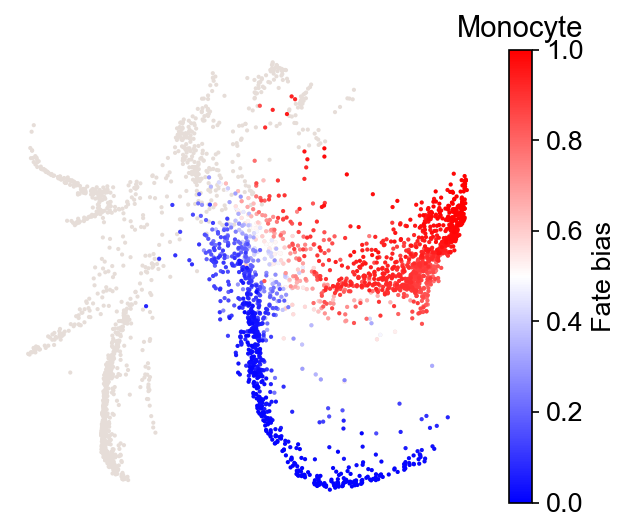

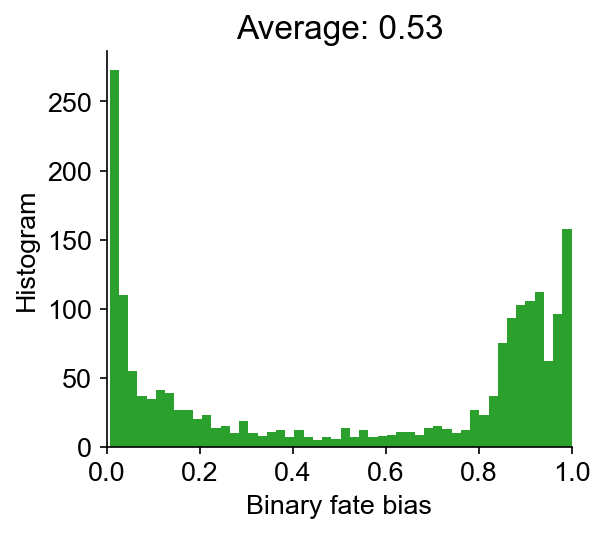

In [39]:
cs.pl.fate_bias_from_binary_competition(adata,selected_fates=['Monocyte','Neutrophil'],
    used_map_name='transition_map',selected_time_points=['4'],plot_target_state=False,
                                map_backwards=True,sum_fate_prob_thresh=0.1)

### Transition map from state information alone

This is the same as `cs.tmap.infer_Tmap_from_one_time_clones`, except that we only compute the initialized map. Let us try the `HighVar` method:

-------------------------------New Start--------------------------------------------------
Current time point: 4
-----------Pre-processing and sub-sampling cells------------
----------------
Step 1: Use highly variable genes to construct pseudo-clones, and apply CoSpar to generate initialized map!
HighVar-v0: avoid cells that have been selected
----------------
Step a: find the commonly shared highly variable genes


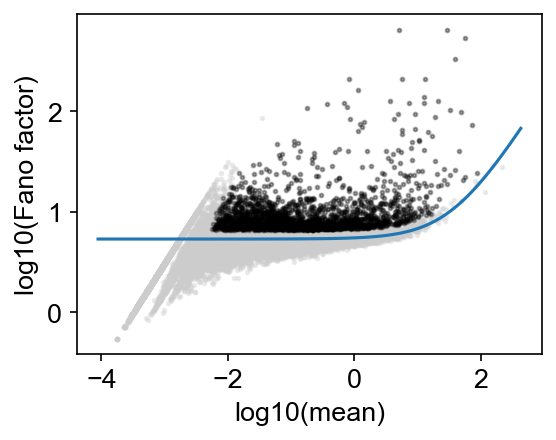

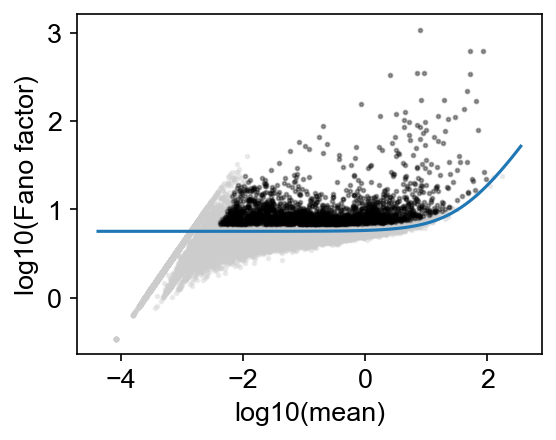

Highly varable gene number at t1 is 2136, Highly varable gene number at t2 is 2245
Common gene set is 978
----------------
Step b: convert the shared highly variable genes into clonal info
No cells left for assignment, total used genes=851
----------------
Step c: compute the transition map based on clonal info from highly variable genes
---------Compute the transition map-----------
Compute similarity matrix: load existing data
--> Time elapsed:  0.10381221771240234
--> Time elapsed:  0.12224984169006348
--> Time elapsed:  0.07846212387084961
--> Time elapsed:  0.12693190574645996
Compute similarity matrix: load existing data
--> Time elapsed:  0.0641319751739502
--> Time elapsed:  0.09478306770324707
--> Time elapsed:  0.06816792488098145
--> Time elapsed:  0.10338807106018066
Compute similarity matrix: load existing data
--> Time elapsed:  0.058098793029785156
--> Time elapsed:  0.0916748046875
--> Time elapsed:  0.08240103721618652
--> Time elapsed:  0.09226799011230469
Current ite

In [40]:
initial_time_points=['4'] #['2','4']
target_time_point='6'
adata=cs.tmap.infer_Tmap_from_state_info_alone(adata_orig,initial_time_points,target_time_point,
        method='HighVar',HighVar_gene_pctl=85,smooth_array=[20,15,10],noise_threshold=0.2,use_full_Smatrix=True)

You can see that this method is not as accurate for this dataset. 

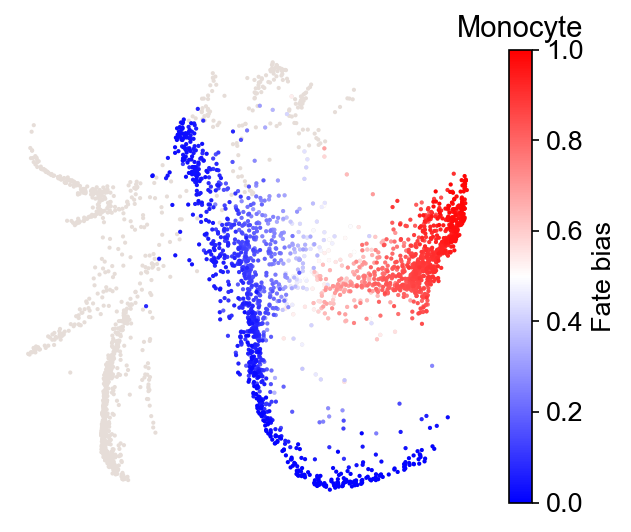

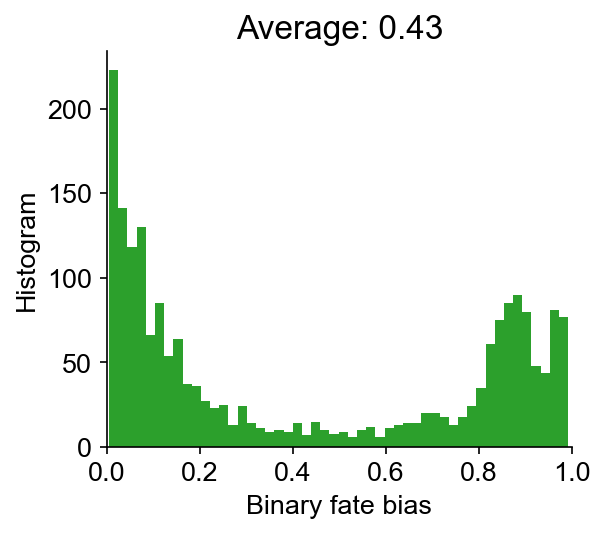

In [41]:
cs.pl.fate_bias_from_binary_competition(adata,selected_fates=['Monocyte','Neutrophil'],
    used_map_name='HighVar_transition_map',selected_time_points=['4'],plot_target_state=False,
                                map_backwards=True,sum_fate_prob_thresh=0.2)

### Gene expression

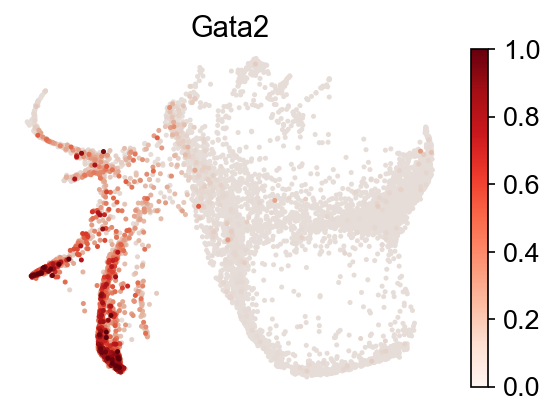

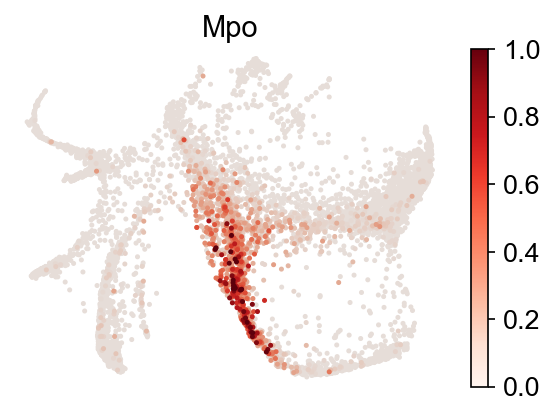

In [42]:
cs.pl.gene_expression_on_manifold(adata,selected_genes=['Gata2','Mpo'],color_bar=True,savefig=False)

### Refine state annotation by marker genes

The goal here is to refine `adata.obs['state_info']`. In this method, a state is selected if it expresses all genes in the list of 
marker_genes, and the expression is above the relative threshold `express_threshold`. 
You can also specify which time point you want to focus on. In addition, we also 
include cell states neighboring to these valid states to smooth 
the selection (controlled by `add_neighbor_N`). First, explore parameters to find satisfactory annotation.

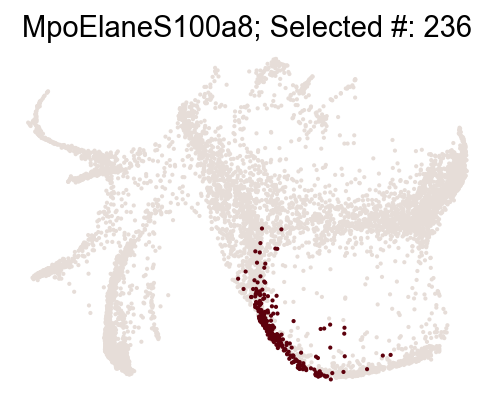

In [43]:
confirm_change=False
marker_genes=['Mpo', 'Elane', 'S100a8']
cs.pp.refine_state_info_by_marker_genes(adata,marker_genes,express_threshold=0.1,
    selected_time_points=['4'],new_cluster_name='new',add_neighbor_N=10,confirm_change=confirm_change)

Now, confirm changes to `adata.obs['state_info']`.

Change state annotation at adata.obs['state_info']


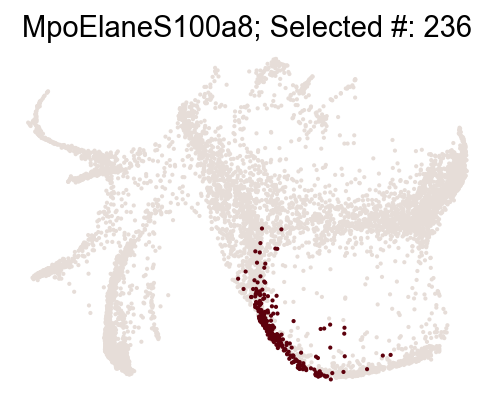

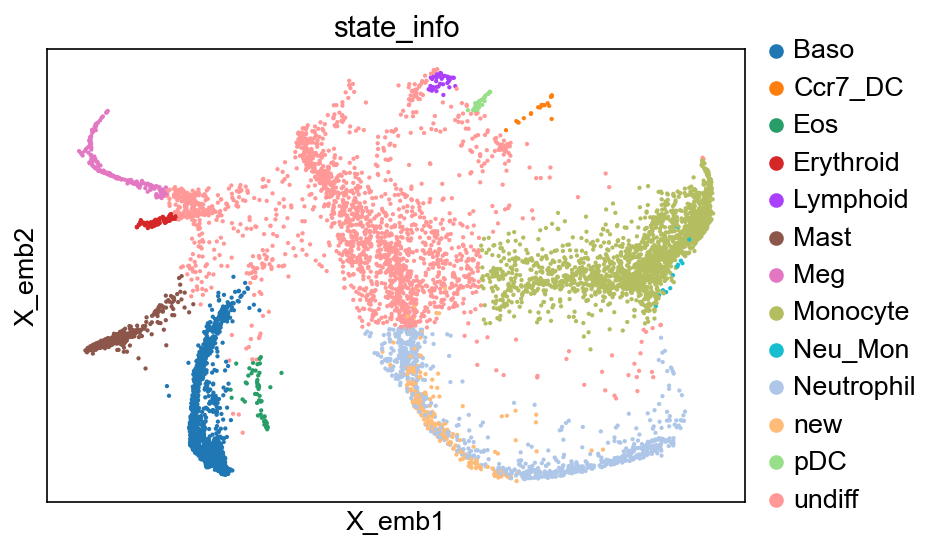

In [44]:
confirm_change=True
marker_genes=['Mpo', 'Elane', 'S100a8']
cs.pp.refine_state_info_by_marker_genes(adata,marker_genes,express_threshold=0.1,
    selected_time_points=['4'],new_cluster_name='new',add_neighbor_N=10,confirm_change=confirm_change)

### Refine state annotation by clustering states at given time points

First, explore the parameters.

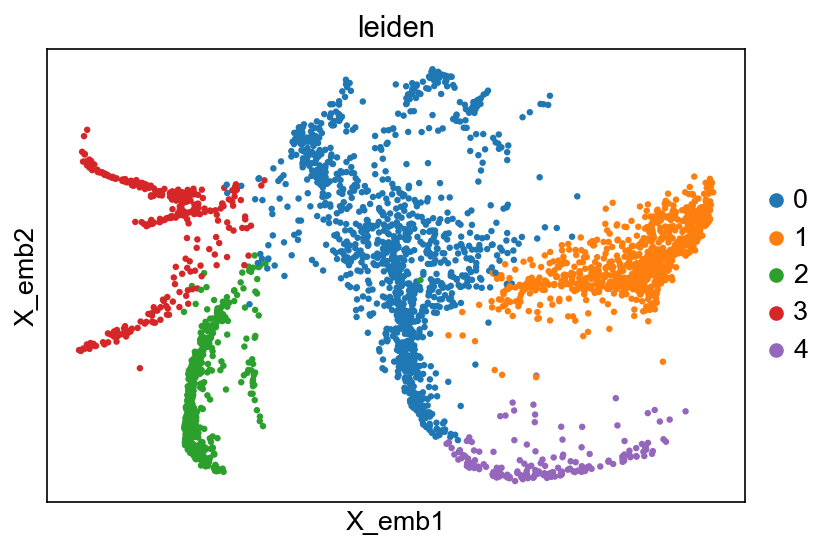

In [45]:
confirm_change=False
cs.pp.refine_state_info_by_leiden_clustering(adata,selected_time_points=['4'],n_neighbors=20,
            resolution=0.1,confirm_change=confirm_change)

Once you are happy with the result, confirm the change to `adata.obs['state_info']`.

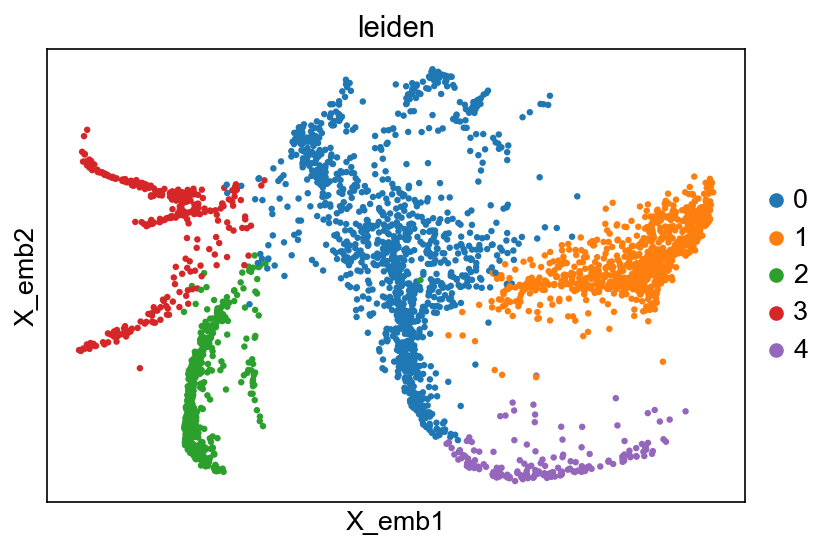

Change state annotation at adata.obs['state_info']


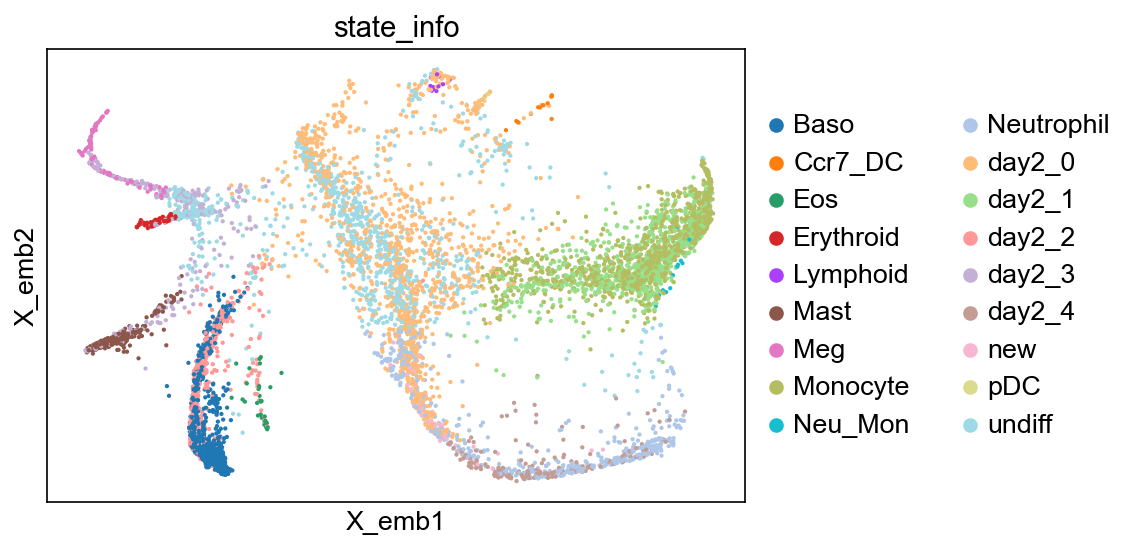

In [46]:
confirm_change=True
cs.pp.refine_state_info_by_leiden_clustering(adata,selected_time_points=['4'],n_neighbors=20,
                    resolution=0.1,confirm_change=confirm_change,cluster_name_prefix='day2_')

### Differential gene expression between two clusters

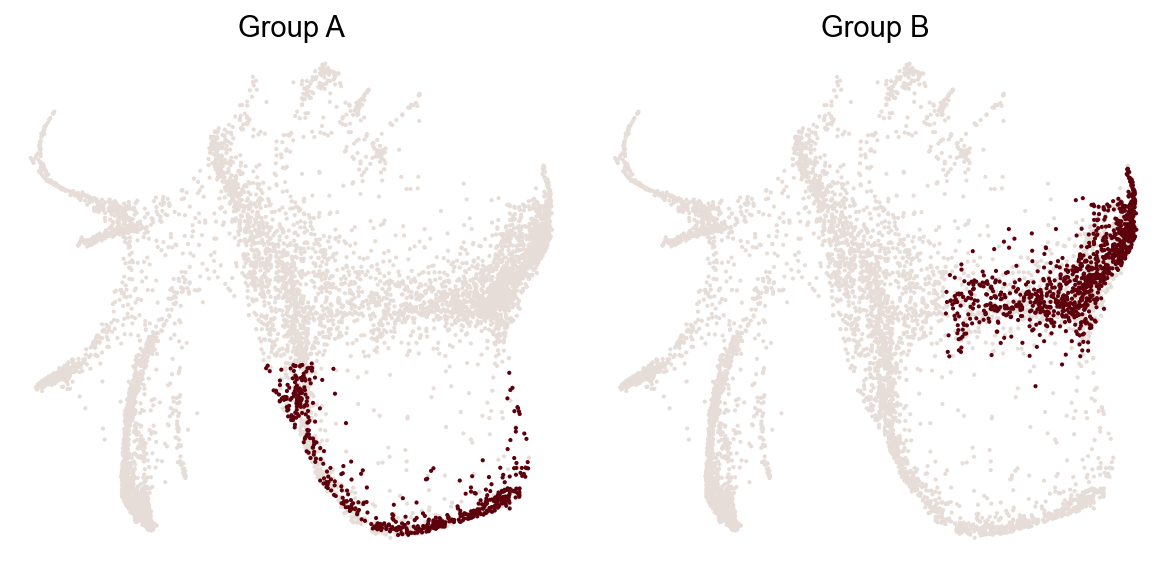

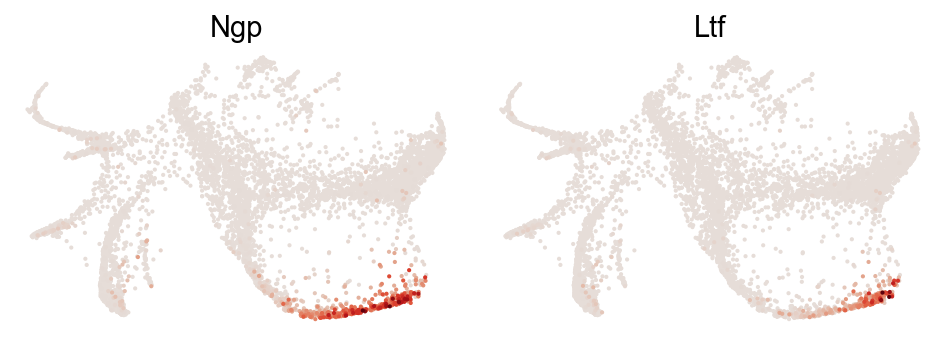

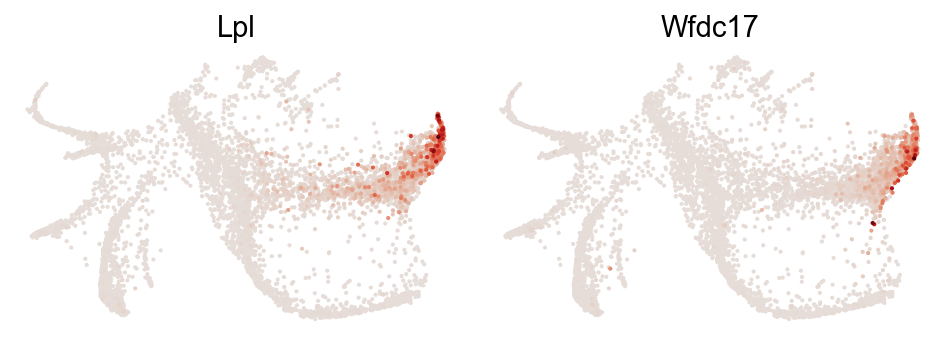

In [47]:
diff_gene_A,diff_gene_B=cs.pl.differential_genes_for_given_fates(adata,selected_fates=['Neutrophil','Monocyte'],
                                    gene_N=100,plot_gene_N=2)

In [48]:
diff_gene_A

gene             pv     mean_1      mean_2     ratio
13             Ngp  1.320889e-140   2.435401  354.415955 -6.692886
49             Ltf   8.475371e-67   0.128121   29.984529 -4.779554
58            Camp   1.609524e-60   0.171137   30.500973 -4.749414
7           S100a9  4.530537e-158  29.539734  488.899445 -4.003726
8           S100a8  2.096021e-156  28.326050  284.073792 -3.281081
..             ...            ...        ...         ...       ...
333         Spint2   7.617320e-17   0.270775    1.659269 -1.065321
174          Hmgb2   9.600749e-31   5.156815   11.883008 -1.065213
251          Abhd5   1.318975e-22   1.529853    4.288892 -1.063912
710  6430548M08Rik   1.083039e-06   0.328479    1.763300 -1.056617
269          Ero1l   3.622832e-20   0.883526    2.912803 -1.054766

[100 rows x 5 columns]